## Exploration of Data

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io as sio
import os

# Load image data
data_load_1 = sio.loadmat('Proj2FeatVecsSet1.mat')
data_load_2 = sio.loadmat('Proj2TargetOutputsSet1.mat')
data_set = data_load_1['Proj2FeatVecsSet1']
data_target = data_load_2['Proj2TargetOutputsSet1']

print(data_set.shape)
print(data_target.shape)

(25000, 60)
(25000, 5)


In [17]:
# Divide my target data into nice 1-D classifier
number_labels = []
for ars in data_target:
    if np.all(ars == [1,-1,-1,-1,-1]):
        ars = 1
        number_labels.append(ars)
    elif np.all(ars == [-1,1,-1,-1,-1]):
        ars = 2
        number_labels.append(ars)
    elif np.all(ars == [-1,-1,1,-1,-1]):
        ars = 3
        number_labels.append(ars)
    elif np.all(ars == [-1,-1,-1,1,-1]):
        ars = 4
        number_labels.append(ars)
    elif np.all(ars == [-1,-1,-1,-1,1]):
        ars = 5
        number_labels.append(ars)
        
number_labels = np.asarray(number_labels)

## Define how many components we should use and run PCA

We need about 9 components to retain 95% of the variance


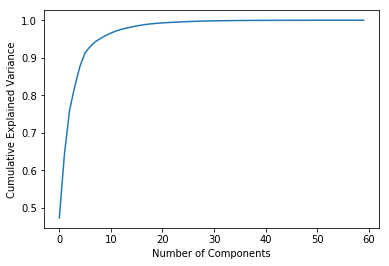

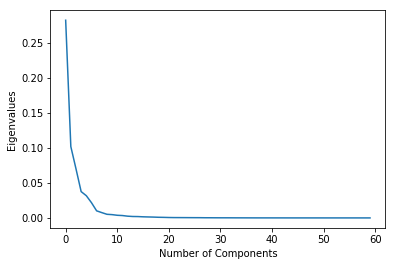

In [4]:
from sklearn.decomposition import PCA
pca = PCA().fit(data_set)
cum_var = np.cumsum(pca.explained_variance_ratio_)
eigenvalues = pca.explained_variance_

count = 0
for var in cum_var:
    count += 1
    if var >= 0.95:
        n_components = count
        answer = "We need about "+ str(n_components) + " components to retain 95% of the variance"
        print(answer)
        break
        
plt.figure(1)
plt.plot(cum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.figure(2)
plt.plot(eigenvalues)
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.show()

# Minumum Noise Factor --> Similar to PCA but removes noise from bands

In [5]:
from sklearn.decomposition import PCA
from skimage.transform import rescale
from sklearn.cluster import KMeans
import numpy as np
import time

#Using PCA
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data_set)
reduced_data.shape

(25000, 9)

## Creation of Data Folds - Training and Testing

In [6]:
from sklearn.model_selection import train_test_split
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    reduced_data, number_labels, test_size=0.20, stratify = number_labels)#, random_state=39)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20000, 9)
(5000, 9)
(20000,)
(5000,)


In [124]:
X_train_1 = X_train[:1000]
X_train_2 = X_train[5000:9999]
X_train_3 = X_train[10000:14999]
X_train_4 = X_train[15000:20000]
y_train_1 = y_train[:1000]
y_train_2 = y_train[5000:9999]
y_train_3 = y_train[10000:14999]
y_train_4 = y_train[15000:20000]

## SVM

In [94]:
from sklearn.svm import SVC
from time import time
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV
# #############################################################################
# Train a SVM classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 1e4, 1e5],
              'gamma': [0.001, 0.01, 0.1] }
clf = OneVsOneClassifier(GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid))
# clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
# clf = OneVsOneClassifier(SVC(**TrainMyClassifierParameters('SVM')))#, gamma = 1)
clf = clf.fit(X_train_1, y_train_1)
print("done in %0.3fs" % (time() - t0))
# clf.score(X_train, y_train)

Fitting the classifier to the training set
done in 34.062s


In [39]:
clf.best_params_

AttributeError: 'OneVsOneClassifier' object has no attribute 'best_params_'

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# #############################################################################
# Quantitative evaluation of the model quality on the test set
print("Predicting class on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Predicting class on the test set
done in 0.597s
             precision    recall  f1-score   support

          1       0.97      0.99      0.98      1000
          2       0.92      0.91      0.91      1000
          3       0.96      0.96      0.96      1000
          4       0.89      0.89      0.89      1000
          5       0.94      0.95      0.94      1000

avg / total       0.94      0.94      0.94      5000

[[986   7   5   0   2]
 [ 12 908   0  77   3]
 [ 11   0 960   3  26]
 [ 10  69   8 886  27]
 [  2   3  24  24 947]]


## RVM

In [12]:
from time import time
from sklearn.multiclass import OneVsOneClassifier
# from sklearn.model_selection import GridSearchCV
from skrvm import RVC
# #############################################################################
# Train a RVM classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 1e4, 1e5],
              'gamma': [0.001, 0.01, 0.1] }
clf = OneVsOneClassifier(GridSearchCV(RVC(kernel='rbf',n_iter=1), param_grid))
# clf = OneVsOneClassifier(RVC(kernel='rbf', n_iter=1))
clf.fit(X_train_1, y_train_1)
print("done in %0.3fs" % (time() - t0))
# # clf.score(X_train, y_train)

Fitting the classifier to the training set
done in 1212.675s


In [17]:
clf.get_params()

{'estimator': GridSearchCV(cv=None, error_score='raise',
        estimator=RVC(alpha=1e-06, beta=1e-06, beta_fixed=False, bias_used=True, coef0=0.0,
   coef1=None, degree=3, kernel='rbf', n_iter=1, n_iter_posterior=50,
   threshold_alpha=1000000000.0, tol=0.001, verbose=False),
        fit_params=None, iid=True, n_jobs=1,
        param_grid={'C': [1000.0, 10000.0, 100000.0], 'gamma': [0.001, 0.01, 0.1]},
        pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
        scoring=None, verbose=0),
 'estimator__cv': None,
 'estimator__error_score': 'raise',
 'estimator__estimator': RVC(alpha=1e-06, beta=1e-06, beta_fixed=False, bias_used=True, coef0=0.0,
   coef1=None, degree=3, kernel='rbf', n_iter=1, n_iter_posterior=50,
   threshold_alpha=1000000000.0, tol=0.001, verbose=False),
 'estimator__estimator__alpha': 1e-06,
 'estimator__estimator__beta': 1e-06,
 'estimator__estimator__beta_fixed': False,
 'estimator__estimator__bias_used': True,
 'estimator__estimator__coef0': 0.

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# #############################################################################
# Quantitative evaluation of the model quality on the test set
print("Predicting class on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Predicting class on the test set
done in 8.635s
             precision    recall  f1-score   support

          1       0.91      0.97      0.94      1000
          2       0.89      0.86      0.88      1000
          3       0.94      0.92      0.93      1000
          4       0.86      0.86      0.86      1000
          5       0.93      0.92      0.93      1000

avg / total       0.91      0.91      0.91      5000

[[967  12  16   1   4]
 [ 30 859   1 105   5]
 [ 39   0 923   6  32]
 [ 12  88  11 863  26]
 [ 14   3  32  31 920]]


## Gaussian Process

In [125]:
# from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from time import time
# #############################################################################
# Train a GPR classification model
print("Fitting the classifier to the training set")
t0 = time()
# clf = GridSearchCV(GaussianProcessRegressor(), param_grid)
k_rbf = RBF(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0))
clf = OneVsOneClassifier(GaussianProcessClassifier(kernel = k_rbf))#kernel = kernel, alpha = 1e-10)#kernel=kernel) # Uses RBF as default
clf.fit(X_train_1, y_train_1)
print("done in %0.3fs" % (time() - t0))
# clf.score(X_train, y_train)

Fitting the classifier to the training set
done in 11.471s


In [126]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# #############################################################################
# Quantitative evaluation of the model quality on the test set
print("Predicting class on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Predicting class on the test set
done in 3.459s
             precision    recall  f1-score   support

          1       0.93      0.96      0.94      1000
          2       0.92      0.87      0.90      1000
          3       0.93      0.92      0.93      1000
          4       0.86      0.88      0.87      1000
          5       0.92      0.93      0.92      1000

avg / total       0.91      0.91      0.91      5000

[[956  12  17   3  12]
 [ 13 870   7 104   6]
 [ 29   4 920  12  35]
 [ 15  57  17 881  30]
 [ 17   0  24  29 930]]


## TrainMyClassifierParameters Function

In [137]:
def TrainMyClassifierParameters(Algorithm):
    if Algorithm == 'SVM':
        Parameters = {
            'C' : [1],
            'gamma' : [1]
        }
    elif Algorithm == 'RVM':
        Parameters = {
            'alpha' : [1e-06],
            'beta' : [1e-06]
        }
    elif Algorithm == 'GP':
        Parameters = {
            'length_scale' : [1.0]             
        }
    return Parameters, Algorithm

## TrainMyClassifier Function

In [135]:
# Not sure if this is the correct type of function we need
def TrainMyClassifier(XEstimate, YEstimate, XValidate, TrainMyClassifierParameters):
    from sklearn.svm import SVC
    from skrvm import RVC
    from sklearn.gaussian_process import GaussianProcessClassifier
    from sklearn.multiclass import OneVsOneClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.gaussian_process.kernels import RBF
    from time import time
    t0 = time()
    # Paramaters should have this shape in order for it to work ==>  Parameters = {'C': [1e3, 1e4, 1e5], 'gamma': [0.001, 0.01, 0.1] }
    if TrainMyClassifierParameters[1] == 'SVM':
        # ################################################
        # Train a SVM classification model
        print("Fitting the classifier to the training set")
        param_grid = TrainMyClassifierParameters[0]
        clf = OneVsOneClassifier(GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid))
        clf = clf.fit(XEstimate, YEstimate)
        y_pred = clf.predict(XValidate)
        scores = clf.score(XEstimate,YEstimate)
        print("done in %0.3fs" % (time() - t0))
        return y_pred, scores
    elif TrainMyClassifierParameters[1] == 'RVM':
        # #############################################################################
        # Train a RVM classification model
        print("Fitting the classifier to the training set")
        t0 = time()
        param_grid = TrainMyClassifierParameters[0]
        clf = OneVsOneClassifier(GridSearchCV(RVC(kernel='rbf',n_iter=1), param_grid))
        clf.fit(XEstimate, YEstimate)
        y_pred = clf.predict(XValidate)
        scores = clf.score(XEstimate,YEstimate)
        print("done in %0.3fs" % (time() - t0))
        return y_pred, scores
    elif TrainMyClassifierParameters[1] == 'GP':
       # #############################################################################
        # Train a GP classification model
        print("Fitting the classifier to the training set")
        t0 = time()
        param_grid = TrainMyClassifierParameters[0]['length_scale']
        k_rbf = RBF(length_scale=param_grid)
        clf = OneVsOneClassifier(GaussianProcessClassifier(kernel = k_rbf))
        clf.fit(X_train_1, y_train_1)
        y_pred = clf.predict(XValidate)
        scores = clf.score(XEstimate,YEstimate)
        print("done in %0.3fs" % (time() - t0))
        return y_pred, scores
    else:
        print("Incorrect type of algorithm, please use only one of the supported classifiers SVM, RVM, GP")

In [136]:
TrainMyClassifier(X_train_1, y_train_1, X_test,TrainMyClassifierParameters('GP'))

Fitting the classifier to the training set
done in 16.434s


(array([2, 1, 3, ..., 1, 4, 1]), 0.932)

## MyConfusionMatrix Function 

In [ ]:
def MyConfusionMatrix(Y,ClassNames):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    c_r = classification_report(y_test, y_pred)
    c_m = confusion_matrix(y_test, y_pred)